In [116]:
from kedro.io import DataCatalog
import yaml
import logging

logger = logging.getLogger(__name__)

with open("catalog.yml") as f:
    conf_catalog = yaml.safe_load(f)

catalog = DataCatalog.from_config(conf_catalog)

with open("parameters.yml", encoding="utf-8") as yaml_file:
    params = yaml.safe_load(yaml_file)

paa_image = catalog.load("paa_12_image")
paa_label = catalog.load("paa_12_label")
paa_roi = catalog.load("paa_12_roi")

epochs = params["tune_sam"]["epochs"]
print(len(paa_image))
print(epochs)

[11/27/24 12:52:34] INFO     Loading data from paa_12_image (PartitionedDataset)...             ]8;id=420220;file://c:\Users\gavin\anaconda3\envs\sam-kedro\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=956328;file://c:\Users\gavin\anaconda3\envs\sam-kedro\lib\site-packages\kedro\io\data_catalog.py#389\389]8;;\

                    INFO     Loading data from paa_12_label (JSONDataset)...                    ]8;id=466878;file://c:\Users\gavin\anaconda3\envs\sam-kedro\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=996900;file://c:\Users\gavin\anaconda3\envs\sam-kedro\lib\site-packages\kedro\io\data_catalog.py#389\389]8;;\

                    INFO     Loading data from paa_12_roi (CSVDataset)...                       ]8;id=594380;file://c:\Users\gavin\anaconda3\envs\sam-kedro\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=271170;file://c:\Users\gavin\anaconda3\envs\sam-kedro\lib\site-packages\kedro\io\data_catalog.py#389\389]8;;\

201
30


# Data Preprocessing: Label and Image Pairing

## Label contstruction from JSON

In [117]:
# from datasets import load_dataset
# dataset = load_dataset("nielsr/breast-cancer", split="train")
from utils.parse_label_json import LabelParser
from typing import List, Dict
import numpy as np

def prepare_masks(label_json: List[Dict]) -> Dict[str, np.ndarray]:
    masks = LabelParser.parse_json(label_json)
    
    # Debug first mask
    sample_key = list(masks.keys())[0]
    sample_mask = masks[sample_key]
    logger.info(f"Sample mask shape: {sample_mask.shape}")
    logger.info(f"Sample mask unique values: {np.unique(sample_mask)}")
    logger.info(f"Sample mask min/max: {sample_mask.min()}, {sample_mask.max()}")
    
    logger.info(f"Prepared {len(masks)} masks from Label Studio JSON")
    logger.info(f"Sample keys of masks: {list(masks.keys())[:5]}")
    
    return masks

masks = prepare_masks(paa_label)
print(len(masks))

193


## Image and Label Pairing

In [118]:
from typing import Callable, Any
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

def prepare_training_data(
    images: Dict[str, Callable[[], Image.Image]],
    masks: Dict[str, np.ndarray],
    params: Dict[str, Any],
    roi: pd.DataFrame,
) -> Dict[str, Any]:
    """Prepare images and masks for SAM fine-tuning."""
    val_split = params.get('val_split', 0.2)
    random_seed = params.get('random_seed', 42)
    
    # Create a mapping of standardized keys
    standardized_images = {
        re.sub(r'image_', '', key): value
        for key, value in images.items()
    }

    # Get sorted list of common keys
    common_keys = sorted(set(standardized_images.keys()) & set(masks.keys()), key=int)
    logger.info(f"Number of matched pairs: {len(common_keys)}")

    # Create matched arrays
    image_dict = {}
    mask_dict = {}

    for key in common_keys:
        image = np.array(standardized_images[key]().convert('RGB'))
        mask = masks[key]
        image_dict[key] = image
        mask_dict[key] = mask

    # Split the keys for train/val
    train_keys, val_keys = train_test_split(
        common_keys,
        test_size=val_split,
        random_state=random_seed
    )

    # Create train/val dictionaries
    train_images = {k: image_dict[k] for k in train_keys}
    train_masks = {k: mask_dict[k] for k in train_keys}
    val_images = {k: image_dict[k] for k in val_keys}
    val_masks = {k: mask_dict[k] for k in val_keys}

    # Extract ROI coordinates
    sample_image = list(image_dict.values())[0]
    box_prompt = np.array([
        max(0, roi['x'].iloc[0]),
        max(0, roi['y'].iloc[0]),
        min(sample_image.shape[1], roi['x'].iloc[0] + roi['width'].iloc[0]),
        min(sample_image.shape[0], roi['y'].iloc[0] + roi['height'].iloc[0])
    ])
    
    logger.info(f"Box prompt coordinates: {box_prompt}")

    return {
        'train': {
            'images': train_images,
            'masks': train_masks,
            'box_prompt': box_prompt
        },
        'val': {
            'images': val_images,
            'masks': val_masks,
            'box_prompt': box_prompt
        }
    }

training_data = prepare_training_data(paa_image, masks, params, paa_roi)


(-0.5, 703.5, 199.5, -0.5)

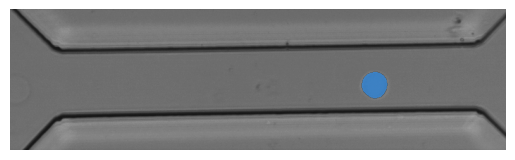

In [119]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Get the first image from training set
train_images = training_data["train"]["images"]
first_key = list(train_images.keys())[0]  # Get the first key (e.g., '86')
image = train_images[first_key]

# Get corresponding mask
train_masks = training_data["train"]["masks"]
mask = train_masks[first_key]

# Get the box prompt (same for all images)
box_prompt = training_data["train"]["box_prompt"]

# To visualize (using your existing plotting code)
fig, ax = plt.subplots()
ax.imshow(image)
show_mask(mask, ax)
ax.axis("off")

In [120]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [121]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, data_dict, processor):
        # data_dict should be training_data['train'] or training_data['val']
        self.images = data_dict['images']
        self.masks = data_dict['masks']
        self.box_prompt = data_dict['box_prompt']
        self.processor = processor
        self.keys = sorted(self.images.keys(), key=int)  # Ensure consistent ordering

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get key for current index
        key = self.keys[idx]
        
        # Get corresponding image and mask
        image = self.images[key]
        ground_truth_mask = self.masks[key]

        # Prepare image and prompt for the model
        # Note: box_prompt is now used directly instead of computing it
        inputs = self.processor(
            image, 
            input_boxes=[[self.box_prompt.tolist()]], 
            return_tensors="pt"
        )
        # Remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # Resize ground truth mask to 256x256
        ground_truth_mask = torch.from_numpy(ground_truth_mask).float()
        ground_truth_mask = torch.nn.functional.interpolate(
            ground_truth_mask.unsqueeze(0).unsqueeze(0),  # Add batch and channel dims
        size=(256, 256),
            mode='nearest'
        ).squeeze(0).squeeze(0)  # Remove batch and channel dims

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [122]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [123]:
train_dataset = SAMDataset(data_dict=training_data["train"], processor=processor)

In [124]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([256, 256])


In [125]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [126]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [127]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [128]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [129]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [130]:
import os
# Create reporting directory if it doesn't exist
os.makedirs("reporting/sam_training", exist_ok=True)
def save_prediction_visualization(image, pred_mask, gt_mask, batch_idx, epoch):
    """Helper function to save visualization"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image - normalize to [0,1] range and convert to correct shape (H,W,C)
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    axes[0].imshow(image_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Predicted mask - convert to binary mask and remove extra dimensions
    pred_mask_np = (pred_mask.cpu().sigmoid() > 0.5).numpy().squeeze()  # Remove any extra dimensions
    axes[1].imshow(pred_mask_np, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    # Ground truth mask - ensure it's 2D
    gt_mask_np = gt_mask.cpu().numpy().squeeze()  # Remove any extra dimensions
    axes[2].imshow(gt_mask_np, cmap='gray')
    axes[2].set_title('Ground Truth Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'reporting/sam_training/epoch_{epoch}_batch_{batch_idx}.png')
    plt.close()

In [131]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch_idx, batch in tqdm(enumerate(train_dataloader)):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

      # Visualize every 10 batches
      if batch_idx % 10 == 0:
          # Get first image from batch for visualization
          save_prediction_visualization(
                image=batch["pixel_values"][0],
                pred_mask=predicted_masks[0],
                gt_mask=ground_truth_masks[0],
                batch_idx=batch_idx,
                epoch=epoch
            )

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

77it [00:25,  2.98it/s]


EPOCH: 0
Mean loss: 0.8344895344275933


77it [00:25,  3.06it/s]


EPOCH: 1
Mean loss: 0.5144525777983975


77it [00:25,  3.08it/s]


EPOCH: 2
Mean loss: 0.3159185769883069


77it [00:24,  3.08it/s]


EPOCH: 3
Mean loss: 0.23620120329516275


30it [00:10,  3.36it/s]